# Systems and Tool Chains for AI Engineers Course Project - Option 1 (FIFA)

## Imports

In [1]:
import os

# PySpark
import pyspark
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, Imputer, StringIndexer, OneHotEncoder
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StandardScaler

# Data Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from streaming.base.converters.dataframe_to_mds import dataframe_to_mds
import streaming
from streaming import StreamingDataset

# ML Libraries
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.types import *
import torch
from torch.utils.data import DataLoader
from torch import nn

## Task 1 - Build and populate necessary tables

In [2]:
appName = "FIFA"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/14 04:09:27 INFO SparkEnv: Registering MapOutputTracker
25/11/14 04:09:27 INFO SparkEnv: Registering BlockManagerMaster
25/11/14 04:09:27 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/11/14 04:09:27 INFO SparkEnv: Registering OutputCommitCoordinator
/usr/lib/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
!gcloud storage ls gs://dataproc-staging-us-central1-868841339359-fpgzyj0u

bucket = "dataproc-staging-us-central1-868841339359-fpgzyj0u"

gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-09T21:28:16.700Z_KDDTrain+.txt
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-09T21:28:26.769Z_KDDTest+.txt
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-10T00:10:37.642Z_postgresql-42.7.8.jar
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-10T05:48:49.253Z_KDDTrain+.txt
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/Course Project.ipynb
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/current_best_model
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_16.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_17.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_18.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_19.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_20.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_

In [4]:
year_file_gender = [
    (2015, f"gs://{bucket}/players_15.csv", "Male"),
    (2016, f"gs://{bucket}/players_16.csv", "Male"),
    (2017, f"gs://{bucket}/players_17.csv", "Male"),
    (2018, f"gs://{bucket}/players_18.csv", "Male"),
    (2019, f"gs://{bucket}/players_19.csv", "Male"),
    (2020, f"gs://{bucket}/players_20.csv", "Male"),
    (2021, f"gs://{bucket}/players_21.csv", "Male"),
    (2022, f"gs://{bucket}/players_22.csv", "Male"),
    (2016, f"gs://{bucket}/female_players_16.csv", "Female"),
    (2017, f"gs://{bucket}/female_players_17.csv", "Female"),
    (2018, f"gs://{bucket}/female_players_18.csv", "Female"),
    (2019, f"gs://{bucket}/female_players_19.csv", "Female"),
    (2020, f"gs://{bucket}/female_players_20.csv", "Female"),
    (2021, f"gs://{bucket}/female_players_21.csv", "Female"),
    (2022, f"gs://{bucket}/female_players_22.csv", "Female")
]

all_dfs_appended = []
for year, path, gender in year_file_gender:
    df = (sqlContext.read.format("csv")
            .option("header", "true")
            .option("inferSchema", "true")
            .option("samplingRatio", "1.0")
            .load(path)
            .withColumn("gender", F.lit(gender))
            .withColumn("year", F.lit(year)))
    all_dfs_appended.append(df)

df_all = None
for df in all_dfs_appended:
    if df_all is None:
        df_all = df
    else:
        df_all = df_all.unionByName(df)
df_all.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |

In [5]:
# Creating Male only dataframe from dataframe that contains both Male and Female
male_df = df_all.filter(F.col('gender') == 'Male')
df_male = male_df
df_male.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |

## Task 2 - Conduct analytics the dataset

### 1. Function to find number of Clubs that had the highest number of Players with contracts ending during $or$ after given Year

In [6]:
def get_top_clubs():
    while True:
        try:
            X = int(input("Enter the year (2015-2022): "))
            if X >= 2015 and X <= 2022:
                break
            else:
                print("Year must be between 2015 and 2022.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    while True:
        try:
            Y = int(input("Enter the number of clubs: "))
            if Y > 0:
                break
            else:
                print("Number of clubs must be positive.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    while True:
        try:
            Z = int(input("Enter the year (2023+): "))
            if Z >= 2023:
                break
            else:
                print("Year must be or after 2023.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    print(f"\n{'='*46}")
    print(f"CONTRACT END YEAR OR AFTER: {Z}")
    print(f"{'='*46}")
    # Filtering the dataframe for the given year and contract end year or after
    df_filtered = df_male.filter((F.col("year") == X))
    df_filtered = df_filtered.filter((F.col("club_contract_valid_until") >= Z))
    df_grouped = df_filtered.groupBy("club_name").count()
    # Sorting the dataframe by the number of players in descending order
    df_sorted = df_grouped.orderBy(F.col("count").desc())

    print(f"Top {Y} clubs")
    print(f"{'='*46}")
    df_result = df_sorted.limit(Y)
    if df_result is not None:
        df_result.show(truncate=False)
    else:
        print("No clubs found")

get_top_clubs()


Enter the year (2015-2022): 2019
Enter the number of clubs: 20
Enter the year (2023+): 2023

CONTRACT END YEAR OR AFTER: 2023
Top 20 clubs


+-------------------------------+-----+
|club_name                      |count|
+-------------------------------+-----+
|Jaguares de Córdoba Fútbol Club|18   |
|Deportivo Pasto                |15   |
|Rionegro Águilas               |15   |
|Junior FC                      |14   |
|Club Deportes Tolima           |14   |
|Patriotas Boyacá FC            |12   |
|La Equidad                     |11   |
|Deportivo Cali                 |10   |
|Alianza Petrolera              |10   |
|Ettifaq FC                     |9    |
|Boyacá Chicó FC                |9    |
|Club Atlético Aldosivi         |9    |
|Dynamo Kyiv                    |9    |
|Orlando City Soccer Club       |9    |
|RC Celta de Vigo               |9    |
|Itagüí Leones FC               |9    |
|Atlético de Madrid             |9    |
|Houston Dynamo                 |9    |
|Club Necaxa                    |8    |
|Sangju Sangmu FC               |8    |
+-------------------------------+-----+



### 2. Function to find number of Clubs with the highest or lowest average Player age for a given Year

In [7]:
def get_clubs_by_average_age():
    while True:
        try:
            X = int(input("Enter the number of clubs to display: "))
            if X > 0:
                break
            else:
                print("Number of clubs must be positive.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    while True:
        try:
            Y = int(input("Enter the year (2015-2022): "))
            if Y >= 2015 and Y <= 2022:
                break
            else:
                print("Year must be between 2015 and 2022.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    while True:
        order_type = input("HIGHEST or LOWEST average age?: ")
        if order_type.lower() == "highest" or order_type.lower() == "lowest":
            break
        else:
            print("Invalid input. Please enter 'Highest' or 'Lowest'.")
    # Checking if the order type is highest or lowest
    if order_type.lower() == "highest":
                # Filtering the dataframe for the given year and sort by the average age in descending order
                df_filtered = df_male.filter((F.col("year") == Y))
                # Grouping the dataframe by the club name and calculating the average age and the number of players
                df_avg_age = df_filtered.groupBy("club_name").agg(
                F.avg("age").alias("avg_age"),
                F.count("age").alias("player_count"))
                # Sorting the dataframe by the average age in descending order
                df_sorted = df_avg_age.orderBy(F.col("avg_age").desc(), F.col("club_name").asc())
                #Considering equal average results on last row
                cutoff_row = df_sorted.limit(X).collect()[-1]
                cutoff_age = cutoff_row["avg_age"]
                df_result = df_sorted.filter(F.col("avg_age") >= cutoff_age)
                
                print(f"\n=== Top {X} clubs ===") 
                print(f"\nSorted by highest average age:") 
                df_result.select("club_name", "avg_age").show(truncate=False)

    else:
        df_filtered = df_male.filter((F.col("year") == Y))
        # Grouping the dataframe by the club name and calculating the average age and the number of players
        df_avg_age = df_filtered.groupBy("club_name").agg(
        F.avg("age").alias("avg_age"),
        F.count("age").alias("player_count"))
        # Sorting the dataframe by the average age in ascending order
        df_sorted = df_avg_age.orderBy(F.col("avg_age").asc(), F.col("club_name").asc())
        #Considering equal average results on last row
        cutoff_row = df_sorted.limit(X).collect()[-1]
        cutoff_age = cutoff_row["avg_age"]
        df_result = df_sorted.filter(F.col("avg_age") <= cutoff_age)

        print(f"\n=== Top {X} clubs ===") 
        print(f"\nSorted by lowest average age:") 
        df_result.select("club_name", "avg_age").show(truncate=False)

get_clubs_by_average_age()

Enter the number of clubs to display: 20
Enter the year (2015-2022): 2019
HIGHEST or LOWEST average age?: highest



=== Top 20 clubs ===

Sorted by highest average age:
+---------------------------------+------------------+
|club_name                        |avg_age           |
+---------------------------------+------------------+
|Paraná                           |31.6              |
|Cruzeiro                         |30.6              |
|Associação Chapecoense de Futebol|30.4              |
|Botafogo                         |30.4              |
|Club Athletico Paranaense        |30.4              |
|Ceará Sporting Club              |30.2              |
|Fluminense                       |30.2              |
|Sport Club do Recife             |30.2              |
|Bahia                            |30.0              |
|Grêmio                           |30.0              |
|Vitória                          |30.0              |
|Internacional                    |29.6              |
|Santos                           |29.6              |
|Akhisar Belediyespor             |29.26923076923077 |
|İstanbul B

### 3. Most Popular Nationality for each Year

In [8]:
def get_most_popular_nationality():
    while True:
        try:
            year = int(input("Enter the year (2015-2022): "))
            if year >= 2015 and year <= 2022:
                break
            else:
                print("Year must be between 2015 and 2022.")
        except ValueError:
            print("Invalid input. Please enter a valid year.")
    # Filtering the dataframe for the given year
    df_filtered = df_male.filter(F.col("year") == year)
    # Grouping the dataframe by the nationality and counting the number of players
    df_grouped = df_filtered.groupBy("nationality_name").count()
    # Sorting the dataframe by the number of players in descending order
    df_sorted = df_grouped.orderBy(F.col("count").desc())
    # Displaying the most popular nationality
    df_sorted.show(1, truncate=False)

get_most_popular_nationality()

Enter the year (2015-2022): 2020


+----------------+-----+
|nationality_name|count|
+----------------+-----+
|England         |1670 |
+----------------+-----+
only showing top 1 row



### 4. Histogram of Player Nationalities across all Years

Enter the number of top nationalities to display: 10


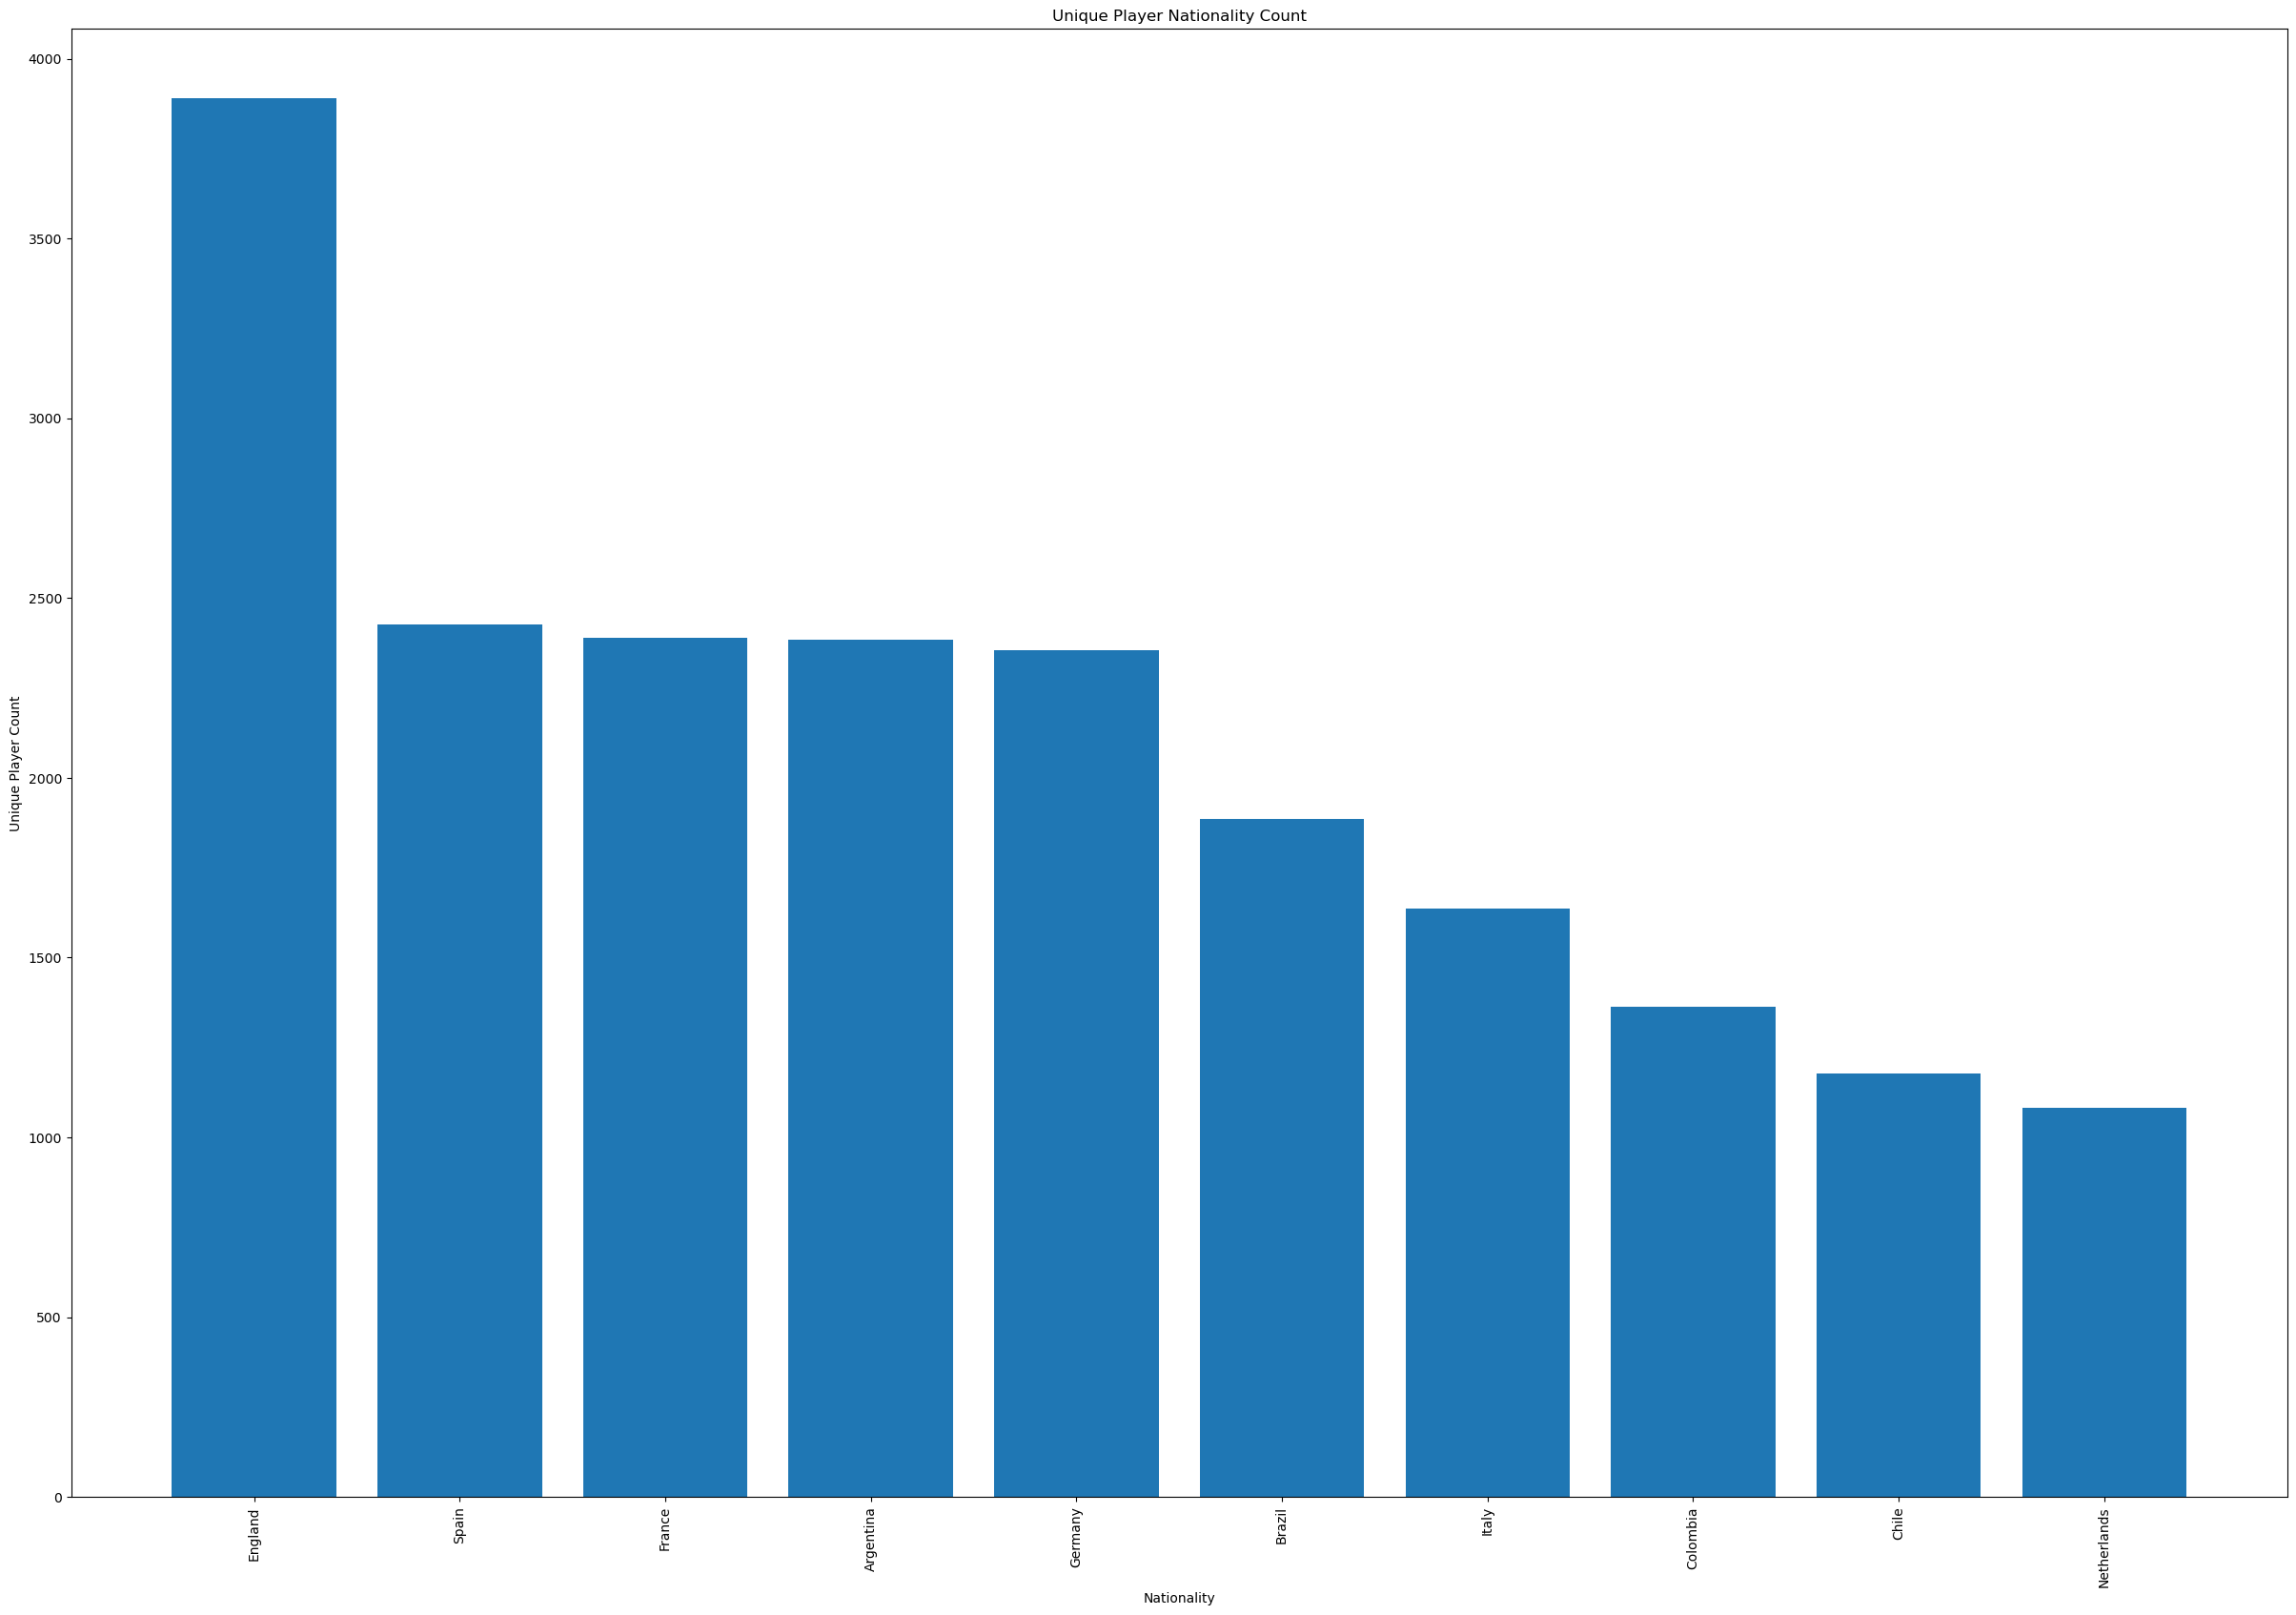

In [9]:
def get_player_nationality_histogram():
    while True:
        try:
            topX = int(input("Enter the number of top nationalities to display: "))
            if topX > 0:
                break
            else:
                print("Number of top nationalities must be positive.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    # Filtering the dataframe for the nationality name
    df_filtered = df_male.select("sofifa_id", "nationality_name")
    # De-duplicating the dataframe
    df_filtered = df_filtered.distinct()
    # Grouping the dataframe by the nationality name and counting the number of players
    df_grouped = df_filtered.groupBy("nationality_name").count()
    # Sorting the dataframe by the number of players in descending order
    df_sorted = df_grouped.orderBy(F.col("count").desc())
    # Limiting the dataframe to the top X nationalities
    tX  = df_sorted.limit(topX).collect()
    counts = [row["count"] for row in tX]
    nationalitys = [row["nationality_name"] for row in tX]
    # Plotting the histogram
    plt.figure(figsize=(30, 20))
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Nationality')
    plt.ylabel('Unique Player Count')
    plt.title('Unique Player Nationality Count')
    plt.xticks(range(len(nationalitys)), nationalitys)
    plt.xticks(rotation=90)

    plt.show()

get_player_nationality_histogram()

### 5. Find popular players in YouTube video comments

Please refer to the project's producer and consumer python files for this task.

## Task 3 - Machine Learning Modeling

In [10]:
df_male.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |

### Remove features that do not possess predictive signal - Not indicative of skillset or overall value

In [11]:
# Player identification and names
player_info_cols = [
    "sofifa_id", "player_url", "short_name", "long_name", "player_positions", "gender"
]

# Club and league information
club_info_cols = [
    "club_name", "league_name", "club_position", "club_loaned_from", "club_team_id",  "league_level",
    "club_joined", "club_contract_valid_until", "release_clause_eur", "club_jersey_number"
]

# Nationality and nation information
nationality_cols = [
    "nationality_name", "nation_position", "nation_jersey_number", "nationality_id", "nation_team_id"
]

# URL columns (images and logos)
url_cols = [
    "player_face_url", "club_logo_url", "club_flag_url",
    "nation_logo_url", "nation_flag_url"
]

# Date columns
date_cols = [
    "dob", "club_contract_expires", "contract_type", "contract_expires_on", "year"
]

# Player attributes and traits
player_attr_cols = [
    "real_face", "player_tags", "player_traits",
    "international_reputation", "age", "preferred_foot",
    "ls", "st", "rs", "lw", "lf", "cf", "rf",
    "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", "lwb", "ldm", 
    "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"
]

columns_to_drop = (
    player_info_cols +
    club_info_cols +
    nationality_cols +
    url_cols +
    date_cols +
    player_attr_cols
)

df_dropped = df_male.drop(*columns_to_drop)
df_dropped.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_short_passing: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_dribbling: integer (nullable = true)
 |-- skill_curve: integ

### Counting Missing Values

In [12]:
# Numeric columns that remain in df_dropped after dropping irrelevant features
numeric_cols = [
    "overall", "value_eur", "wage_eur", "height_cm", "weight_kg", "weak_foot", "skill_moves", 
    "pace", "shooting", "passing", "dribbling",
    "defending", "physic", "attacking_crossing", "attacking_finishing",
    "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys",
    "skill_dribbling", "skill_curve", "skill_fk_accuracy", "skill_long_passing",
    "skill_ball_control", "movement_acceleration", "movement_sprint_speed",
    "movement_agility", "movement_reactions", "movement_balance", "power_shot_power",
    "power_jumping", "power_stamina", "power_strength", "power_long_shots",
    "mentality_aggression", "mentality_interceptions", "mentality_positioning",
    "mentality_vision", "mentality_penalties", "mentality_composure",
    "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
    "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed"
]

# Text columns that remain in df_dropped after dropping irrelevant features
text_cols = ["work_rate", "body_type"]

total_rows = df_dropped.count()

null_df = df_dropped.select(
    *[count(when(col(c).isNull(), 1)).alias(c) for c in numeric_cols],
    *[count(when(col(c).isNull() | ((col(c))=="") | upper((col(c))).isin("NA","N/A","NULL"), 1)).alias(c) for c in text_cols]
)

nulls_row_list = null_df.collect()
if nulls_row_list:
    nulls_row = nulls_row_list[0]
    print(f"{'Column':30} | {'# Missing':10} | {'% Missing':10}")
    print("=" * 57)
    every_col = numeric_cols + text_cols
    for c in every_col:
        missing = nulls_row[c]
        percent = (missing / total_rows * 100)
        print(f"{c:30} | {missing:10} | {percent:9.2f}%")

25/11/14 04:11:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Column                         | # Missing  | % Missing 
overall                        |          0 |      0.00%
value_eur                      |       1897 |      1.34%
wage_eur                       |       1622 |      1.14%
height_cm                      |          0 |      0.00%
weight_kg                      |          0 |      0.00%
weak_foot                      |          0 |      0.00%
skill_moves                    |          0 |      0.00%
pace                           |      15791 |     11.11%
shooting                       |      15791 |     11.11%
passing                        |      15791 |     11.11%
dribbling                      |      15791 |     11.11%
defending                      |      15791 |     11.11%
physic                         |      15791 |     11.11%
attacking_crossing             |          0 |      0.00%
attacking_finishing            |          0 |      0.00%
attacking_heading_accuracy     |          0 |      0.00%
attacking_short_passing        

In [14]:
# Dropping goalkeeping_speed as it has %88.89 missing values
df_dropped = df_dropped.drop("goalkeeping_speed")
# Dropping potential as it is very similar to overall
df_dropped = df_dropped.drop("potential")
# Casting value_eur, wage_eur, mentality_composure to double as they were cast as strings. 
# This was not an issue in the local notebook.
df_dropped = df_dropped.withColumn('value_eur', F.col('value_eur').cast('double'))
df_dropped = df_dropped.withColumn('wage_eur', F.col('wage_eur').cast('double'))
df_dropped = df_dropped.withColumn('mentality_composure', F.col('mentality_composure').cast('integer'))
df_dropped.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_short_passing: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_dribbling: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- skill_fk_accurac

### Imputation

In [15]:
# Numeric columns in df_dropped
numeric_cols = [
    "overall", "value_eur", "wage_eur", "height_cm", "weight_kg", "weak_foot", "skill_moves",
    "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy",
    "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve",
    "skill_fk_accuracy", "skill_long_passing", "skill_ball_control",
    "movement_acceleration", "movement_sprint_speed", "movement_agility",
    "movement_reactions", "movement_balance", "power_shot_power", "power_jumping",
    "power_stamina", "power_strength", "power_long_shots", "mentality_aggression",
    "mentality_interceptions", "mentality_positioning", "mentality_vision",
    "mentality_penalties", "mentality_composure", "defending_marking_awareness",
    "defending_standing_tackle", "defending_sliding_tackle", "goalkeeping_diving",
    "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning",
    "goalkeeping_reflexes"
]

# Text columns in df_dropped
text_cols = ["work_rate", "body_type"]

df_numeric_only = df_dropped.select(*numeric_cols)

null_counts = df_numeric_only.select(*[F.count(when(F.col(c).isNull(), 1)).alias(c) for c in numeric_cols])

# Identify which columns have missing values
columns_to_impute = []
for col_name in numeric_cols:
    null_count = null_counts.select(col_name).collect()[0][0]
    if null_count > 0:
        columns_to_impute.append(col_name)

columns_to_exclude = ["overall"]
columns_to_impute = [c for c in columns_to_impute if c not in columns_to_exclude]

print("\nNull counts BEFORE Imputation:")
print("=" * 30)
null_counts.select(*columns_to_impute).show(truncate=False)

value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = df_numeric_only.fillna(value_not_in_dataset, columns_to_impute)

# Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer(
    inputCols=columns_to_impute,
    outputCols=[f"{c}_imputed" for c in columns_to_impute])\
    .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)

# Drop the old columns without imputation
df_imputed_enhanced = df_imputed.drop(*columns_to_impute)

# Rename the newly imputed columns with the correct names
df_numeric_filled = df_imputed_enhanced
for c in columns_to_impute:
    df_numeric_filled = df_numeric_filled.withColumnRenamed(f"{c}_imputed", c)

print("Null counts AFTER Imputation:")
print("=" * 29)
df_numeric_filled.select(*[F.count(when(F.col(c).isNull(), 1)).alias(c) for c in columns_to_impute]).show(truncate=False)

# Add text_cols back to df_numeric_filled
# CITATION: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.monotonically_increasing_id.html
# I used this to add a unique identifier to each row in the dataframe so I could join the numeric and text columns back together after imputation
df_numeric_filled_with_id = df_numeric_filled.withColumn("row_id", monotonically_increasing_id())
df_text_cols = df_dropped.select(*text_cols).withColumn("row_id", monotonically_increasing_id())

df_fully_imputed = df_numeric_filled_with_id.join(df_text_cols, on="row_id", how="inner").drop("row_id")
df_fully_imputed.show(5)


Null counts BEFORE Imputation:


+---------+--------+-----+--------+-------+---------+---------+------+-------------------+
|value_eur|wage_eur|pace |shooting|passing|dribbling|defending|physic|mentality_composure|
+---------+--------+-----+--------+-------+---------+---------+------+-------------------+
|1897     |1622    |15791|15791   |15791  |15791    |15791    |15791 |31778              |
+---------+--------+-----+--------+-------+---------+---------+------+-------------------+



Null counts AFTER Imputation:


+---------+--------+----+--------+-------+---------+---------+------+-------------------+
|value_eur|wage_eur|pace|shooting|passing|dribbling|defending|physic|mentality_composure|
+---------+--------+----+--------+-------+---------+---------+------+-------------------+
|0        |0       |0   |0       |0      |0        |0        |0     |0                  |
+---------+--------+----+--------+-------+---------+---------+------+-------------------+



+-------+---------+---------+---------+-----------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+---------------------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+---------+--------+----+--------+-------+---------+---------+------+-------------------+-------------+----------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_finishing|attacking_heading_accuracy|attacking_short_passing|attacking_volleys|skill_dribbling|

### Handling Outliers

In [16]:
def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    
    # Adding all the outlier columns into a new column "total_outliers", to see the total number of outliers
    # Check if selected_columns is not empty before using reduce()
    if len(selected_columns) > 0:
        df = df.withColumn('total_outliers', reduce(column_add, (df[col] for col in selected_columns)))
    else:
        # If no outlier columns were created, set total_outliers to 0
        df = df.withColumn('total_outliers', F.lit(0))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [17]:
df_fully_imputed.summary().show(truncate=False, vertical=True)

-RECORD 0-----------------------------------------
 summary                     | count              
 overall                     | 142079             
 height_cm                   | 142079             
 weight_kg                   | 142079             
 weak_foot                   | 142079             
 skill_moves                 | 142079             
 attacking_crossing          | 142079             
 attacking_finishing         | 142079             
 attacking_heading_accuracy  | 142079             
 attacking_short_passing     | 142079             
 attacking_volleys           | 142079             
 skill_dribbling             | 142079             
 skill_curve                 | 142079             
 skill_fk_accuracy           | 142079             
 skill_long_passing          | 142079             
 skill_ball_control          | 142079             
 movement_acceleration       | 142079             
 movement_sprint_speed       | 142079             
 movement_agility            | 

In [18]:
df_with_outlier_handling = find_outliers(df_fully_imputed)
df_with_outlier_handling.groupby("total_outliers").count().orderBy(F.col("total_outliers").asc()).show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             0|69809|
|             1|45583|
|             2| 7296|
|             3| 2381|
|             4|  747|
|             5|  456|
|             6|  683|
|             7| 1622|
|             8| 2806|
|             9| 2951|
|            10| 2599|
|            11| 1604|
|            12| 1130|
|            13|  975|
|            14|  806|
|            15|  407|
|            16|  177|
|            17|   46|
|            19|    1|
+--------------+-----+



In [19]:
# Filtering out rows with more than 7 outliers
print(f"Before filtering: {df_with_outlier_handling.count()}")
df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_Outliers']<=7)
print(f"After filtering: {df_with_substituted_na_and_outliers.count()}")

Before filtering: 142079


After filtering: 128577


### Correlation Matrix

In [20]:
# Correlation matrix
correlation_matrix = df_with_substituted_na_and_outliers.select(*numeric_cols).toPandas().corr()
print(correlation_matrix)

                              overall  value_eur  wage_eur  height_cm  \
overall                      1.000000   0.576898  0.621521   0.073887   
value_eur                    0.576898   1.000000  0.777158   0.025243   
wage_eur                     0.621521   0.777158  1.000000   0.045981   
height_cm                    0.073887   0.025243  0.045981   1.000000   
weight_kg                    0.166975   0.050538  0.085974   0.750968   
weak_foot                    0.215075   0.143788  0.143845  -0.101659   
skill_moves                  0.358993   0.283857  0.250352  -0.303765   
pace                         0.185607   0.170042  0.144775  -0.403180   
shooting                     0.476365   0.302321  0.318640  -0.183914   
passing                      0.668949   0.393093  0.421243  -0.265590   
dribbling                    0.592770   0.381442  0.385588  -0.386460   
defending                    0.319817   0.128654  0.167523   0.220058   
physic                       0.507090   0.208490  0

In [21]:
# Finding high correlation pairs
threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = float(correlation_matrix.iloc[i, j])
        if np.abs(corr) >= threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr
            })

high_corr_pairs.sort(key=lambda x: np.abs(x['correlation']), reverse=True)

if len(high_corr_pairs) > 0:
    print(f"\n{'Feature 1':40} {'Feature 2':40} {'Correlation':10}")
    print("=" * 100)
    for pair in high_corr_pairs:
        print(f"{pair['feature1']:40} {pair['feature2']:40} {pair['correlation']:10}")
else:
    print("No high correlation pairs")


Feature 1                                Feature 2                                Correlation
defending_standing_tackle                defending_sliding_tackle                 0.9660588721948731
defending                                defending_standing_tackle                0.9455378688328557
pace                                     movement_sprint_speed                    0.9352026590660413
defending                                defending_marking_awareness              0.9347898822248574
defending                                defending_sliding_tackle                 0.9333909786473619
defending                                mentality_interceptions                  0.9270576588208799
pace                                     movement_acceleration                    0.9253863280469865
mentality_interceptions                  defending_standing_tackle                0.9238593887636289
shooting                                 attacking_finishing                      0.9234644079406

In [22]:
# Dropping features with high correlation with other features
df_with_handled_correlations_and_dropped_features = df_with_substituted_na_and_outliers.drop("goalkeeping_reflexes", 
                                        "movement_acceleration", "movement_sprint_speed", 
                                        "defending_standing_tackle", "defending_sliding_tackle",
                                        "mentality_interceptions", "goalkeeping_handling", "goalkeeping_positioning"
                                        "goalkeeping_kicking", "goalkeeping_handling", "goalkeeping_diving",
                                        "attacking_finishing", "attacking_short_passing", "attacking_volleys",
                                        "defending_marking_awareness", "skill_dribbling", "power_long_shots",
                                        "skill_ball_control", "power_shot_power", "mentality_vision",
                                        "dribbling", "skill_long_passing", "goalkeeping_positioning",
                                        "power_strength", "movement_reactions"
                                        )

# We iterated through this process of adding features to the list of features to drop and then 
# checking if there are any remaining correlations with correlation coefficient greater than 0.8 multiple times 
# to drop features with high correlation with other features. The above list is the final list of features that we dropped.

# Checking if there are any remaining correlations with correlation coefficient greater than 0.8
numeric_cols_with_dropped_features = [c for c in numeric_cols if c in df_with_handled_correlations_and_dropped_features.columns]

correlation_matrix_with_dropped_features = df_with_handled_correlations_and_dropped_features\
    .select(*numeric_cols_with_dropped_features).toPandas().corr()

threshold = 0.8
high_corr_pairs_with_dropped_features = []

for i in range(len(correlation_matrix_with_dropped_features.columns)):
    for j in range(i+1, len(correlation_matrix_with_dropped_features.columns)):
        corr = float(correlation_matrix_with_dropped_features.iloc[i, j])
        if np.abs(corr) >= threshold:
            high_corr_pairs_with_dropped_features.append({
                'feature1': correlation_matrix_with_dropped_features.columns[i],
                'feature2': correlation_matrix_with_dropped_features.columns[j],
                'correlation': corr
            })

high_corr_pairs_with_dropped_features.sort(key=lambda x: np.abs(x['correlation']), reverse=True)

if len(high_corr_pairs_with_dropped_features) > 0:
    print(f"\n{'Feature 1':40} {'Feature 2':40} {'Correlation':10}")
    print("=" * 100)
    for pair in high_corr_pairs_with_dropped_features:
        print(f"{pair['feature1']:40} {pair['feature2']:40} {pair['correlation']:10}")
else:
    print("No high correlation pairs")

No high correlation pairs


In [23]:
df_with_handled_correlations_and_dropped_features = df_with_handled_correlations_and_dropped_features.drop("total_outliers")
df_with_handled_correlations_and_dropped_features.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- skill_fk_accuracy: integer (nullable = true)
 |-- movement_agility: integer (nullable = true)
 |-- movement_balance: integer (nullable = true)
 |-- power_jumping: integer (nullable = true)
 |-- power_stamina: integer (nullable = true)
 |-- mentality_aggression: integer (nullable = true)
 |-- mentality_positioning: integer (nullable = true)
 |-- mentality_penalties: integer (nullable = true)
 |-- goalkeeping_kicking: integer (nullable = true)
 |-- value_eur: double (nullable = false)
 |-- wage_eur: double (nullable = false)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integ

### Handling Ordinal and Nominal Variables

In [24]:
continuous_cols = ["overall", "height_cm", "weight_kg", "weak_foot", "skill_moves", "attacking_crossing", 
                    "attacking_heading_accuracy", "skill_curve", "skill_fk_accuracy", "movement_agility", 
                    "movement_balance", "power_jumping", "power_stamina", "mentality_aggression", "mentality_positioning", 
                    "mentality_penalties", "goalkeeping_kicking", "value_eur", "wage_eur", "pace", "shooting", "passing", 
                    "defending", "physic", "mentality_composure"]

ordinal_cols = ["work_rate"]

nominal_cols = ["body_type"]

In [25]:
# Ordinal Variables
indexer = StringIndexer(inputCol="work_rate", outputCol="work_rate_index")
df_ordinal_handled = indexer.fit(df_with_handled_correlations_and_dropped_features).transform(df_with_handled_correlations_and_dropped_features)
df_ordinal_handled.show(5)
print("Ordinal Indexed DataFrame:")
# Dropping the original work_rate column
df_ordinal_handled = df_ordinal_handled.drop("work_rate")
print("Ordinal Indexed Dropped DataFrame:")
df_ordinal_handled.show(5)

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+-----------+----------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|  work_rate|       body_type|work_rate_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+-------------------

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+----------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|       body_type|work_rate_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+

In [26]:
# Nominal Variables
indexer = StringIndexer(inputCol="body_type", outputCol="body_type_index")
df_nominal_handled = indexer.fit(df_ordinal_handled).transform(df_ordinal_handled)
print("Nominal Indexed DataFrame:")
df_nominal_handled.show(5)
# Dropping the original body_type column
df_nominal_handled = df_nominal_handled.drop("body_type")
print("Nominal Indexed Dropped DataFrame:")
df_nominal_handled.show(5)

encoder = OneHotEncoder(inputCols=["body_type_index"], outputCols=["body_type_encoded"])
df_nominal_encoded = encoder.fit(df_nominal_handled).transform(df_nominal_handled)
print("Nominal Encoded DataFrame:")
df_nominal_encoded.show(5)
# Dropping the original body_type_index column
df_nominal_encoded = df_nominal_encoded.drop("body_type_index")
print("Final Nominal Encoded DataFrame:")
df_nominal_encoded.show(5)


Nominal Indexed DataFrame:


+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+----------------+---------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|       body_type|work_rate_index|body_type_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+-----------

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+---------------+---------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|work_rate_index|body_type_index|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+--

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+---------------+---------------+-----------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|work_rate_index|body_type_index|body_type_encoded|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+---------

+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+---------------------+-------------------+-------------------+---------+--------+----+--------+-------+---------+------+-------------------+---------------+-----------------+
|overall|height_cm|weight_kg|weak_foot|skill_moves|attacking_crossing|attacking_heading_accuracy|skill_curve|skill_fk_accuracy|movement_agility|movement_balance|power_jumping|power_stamina|mentality_aggression|mentality_positioning|mentality_penalties|goalkeeping_kicking|value_eur|wage_eur|pace|shooting|passing|defending|physic|mentality_composure|work_rate_index|body_type_encoded|
+-------+---------+---------+---------+-----------+------------------+--------------------------+-----------+-----------------+----------------+----------------+-------------+-------------+--------------------+--------------------

In [27]:
df_nominal_encoded.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- skill_curve: integer (nullable = true)
 |-- skill_fk_accuracy: integer (nullable = true)
 |-- movement_agility: integer (nullable = true)
 |-- movement_balance: integer (nullable = true)
 |-- power_jumping: integer (nullable = true)
 |-- power_stamina: integer (nullable = true)
 |-- mentality_aggression: integer (nullable = true)
 |-- mentality_positioning: integer (nullable = true)
 |-- mentality_penalties: integer (nullable = true)
 |-- goalkeeping_kicking: integer (nullable = true)
 |-- value_eur: double (nullable = false)
 |-- wage_eur: double (nullable = false)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integ

### Vector Assembly

In [28]:
feature_list = df_nominal_encoded.drop("overall").columns
print("Feature List:")
for feature in feature_list:
    print(feature)

vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_nominal_encoded.withColumn("label", col("overall")))

Feature List:
height_cm
weight_kg
weak_foot
skill_moves
attacking_crossing
attacking_heading_accuracy
skill_curve
skill_fk_accuracy
movement_agility
movement_balance
power_jumping
power_stamina
mentality_aggression
mentality_positioning
mentality_penalties
goalkeeping_kicking
value_eur
wage_eur
pace
shooting
passing
defending
physic
mentality_composure
work_rate_index
body_type_encoded


In [29]:
df_with_assembled_features.select("vectorized_features","label")\
    .distinct().toPandas()

,vectorized_features,label
0,"[188.0, 83.0, 2.0, 1.0, 25.0, 25.0, 32.0, 21.0...",81
1,"[176.0, 70.0, 4.0, 2.0, 83.0, 65.0, 75.0, 30.0...",77
2,"[178.0, 66.0, 3.0, 2.0, 64.0, 63.0, 60.0, 27.0...",68
3,"[187.0, 78.0, 3.0, 3.0, 67.0, 55.0, 66.0, 58.0...",67
4,"[185.0, 77.0, 4.0, 2.0, 69.0, 39.0, 50.0, 52.0...",67
...,...,...
128400,"[175.0, 67.0, 3.0, 2.0, 53.0, 50.0, 48.0, 43.0...",61
128401,"[182.0, 78.0, 3.0, 2.0, 44.0, 54.0, 34.0, 28.0...",59
128402,"[176.0, 64.0, 4.0, 3.0, 48.0, 37.0, 57.0, 52.0...",59
128403,"[185.0, 76.0, 2.0, 2.0, 24.0, 51.0, 20.0, 20.0...",56


### Data Scaling

In [30]:
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("features", "label").distinct().toPandas()

,features,label
0,"[28.54018507373034, 10.75390584817462, 7.85051...",76
1,"[28.0773712617239, 11.500704865408968, 4.71031...",74
2,"[29.002998885736776, 12.695583292983926, 4.710...",71
3,"[28.385913803061523, 12.396863686090187, 3.140...",69
4,"[29.002998885736776, 12.546223489537056, 4.710...",67
...,...,...
128400,"[29.92862650974965, 13.143662703324535, 3.1402...",62
128401,"[27.923099991055086, 11.500704865408968, 6.280...",61
128402,"[27.768828720386274, 11.20198525851523, 4.7103...",57
128403,"[26.226116013698146, 10.455186241280881, 4.710...",53


## Model Training

### Spark

In [31]:
# Data Split
train_data, test_data = df_with_scaled_features.randomSplit([0.8, 0.2], seed= 13)

#### Model 1: Random Forest

In [32]:
# Create Regression Evaluator
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# Initialize Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
)

# Parameter Grid for Hyperparameter Tuning
rf_param_grid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10])
    .addGrid(rf.maxDepth, [5])
    .build()
)

# CrossValidator for Hyperparameter Tuning
rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=4,
    seed=13
)

# Train the model with cross-validation on training data
rf_cv_model = rf_cv.fit(train_data)

# Get the best model from cross-validation
best_model = rf_cv_model.bestModel # Citation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidatorModel.html

# Best Model
best_rf_model = best_model
print(f"Best model parameters:")
print(f"Number of Trees: {best_rf_model.getNumTrees}")
print(f"Max Depth: {best_rf_model.getMaxDepth()}")

# Test evaluation
rf_test_predictions = best_rf_model.transform(test_data)
test_rmse = evaluator.evaluate(rf_test_predictions)
print(f"Test RMSE: {test_rmse:.4f}")

Best model parameters:
Number of Trees: 10
Max Depth: 5


Test RMSE: 1.8468


#### Model 2: Linear Regression

In [33]:
# Create Regression Evaluator
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# Initialize Linear Regression
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
)

# Parameter Grid for Hyperparameter Tuning
lr_param_grid = (ParamGridBuilder()
    .addGrid(lr.maxIter, [5])
    .addGrid(lr.regParam, [0.00001])
    .build()
)

# CrossValidator for Hyperparameter Tuning
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=4,
    seed=13
)

# Train the model with cross-validation on training data
lr_cv_model = lr_cv.fit(train_data)

# Get the best model from cross-validation
best_model = lr_cv_model.bestModel # Citation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidatorModel.html

# Best Model
best_lr_model = best_model
print(f"Best model parameters:")
print(f"maxIter: {best_lr_model.getMaxIter()}")
print(f"regParam: {best_lr_model.getRegParam()}")

# Test evaluation
lr_test_predictions = best_lr_model.transform(test_data)
test_rmse = evaluator.evaluate(lr_test_predictions)
print(f"Test RMSE: {test_rmse:.4f}")

Best model parameters:
maxIter: 5
regParam: 1e-05


Test RMSE: 3.0604


### PyTorch

In [45]:
# Data Split
py_train_data, py_val_data, py_test_data = df_with_scaled_features.randomSplit([0.7, 0.15, 0.15], seed= 13)

In [46]:
# Define the function that write the Spark DataFrame to files using `mosaic-streaming`
def write_df_to_mds(outpath,dataframe):
    # Convert the Spark DataFrame to a format that can be written to MDS, mainliy converting the vector column to array column
    dataframe_converted = dataframe.withColumn("features", vector_to_array("features"))\
                                   .withColumn("features",col("features").cast(ArrayType(FloatType(), True)))\
                                   .withColumn("label",col("label").cast(LongType()))
    mds_kwargs = {
    "out": outpath,
    "columns": {"features": "ndarray:float32", "label": "int64"}
    }
    dataframe_to_mds(
        dataframe_converted,
        mds_kwargs = mds_kwargs
    )

write_df_to_mds(f"gs://{bucket}/train_mds", py_train_data)
write_df_to_mds(f"gs://{bucket}/test_mds", py_test_data)
write_df_to_mds(f"gs://{bucket}/val_mds", py_val_data)

In [47]:
!gcloud storage ls gs://dataproc-staging-us-central1-868841339359-fpgzyj0u

bucket = "dataproc-staging-us-central1-868841339359-fpgzyj0u"

gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-09T21:28:16.700Z_KDDTrain+.txt
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-09T21:28:26.769Z_KDDTest+.txt
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-10T00:10:37.642Z_postgresql-42.7.8.jar
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/2025-10-10T05:48:49.253Z_KDDTrain+.txt
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/Course Project.ipynb
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/current_best_model
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_16.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_17.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_18.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_19.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_20.csv
gs://dataproc-staging-us-central1-868841339359-fpgzyj0u/female_players_

#### Model 1: Multi-Layer Perceptron (Deep - 4 Hidden Layers)

In [38]:
class RegressionMLPDeep(nn.Module):
    def __init__(self, input_dim=34):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [39]:
os.environ['PYTHONWARNINGS'] = 'ignore'

# Hyperparameter grid
hyperparameter_grid = {
    'lr': [0.001],
    'batch_size': [64],
    'N_epochs': [1]
}

# Create loss function
loss_fun = nn.MSELoss()

# Track best model
best_overall_val_loss = float('inf')
best_hyperparams = None

for lr in hyperparameter_grid['lr']:
    for batch_size in hyperparameter_grid['batch_size']:
        for N_epochs in hyperparameter_grid['N_epochs']:
            print(f"Training with: lr={lr}, batch_size={batch_size}, epochs={N_epochs}")
            
            # Initialize model for this hyperparameter combination
            mymodel = RegressionMLPDeep()
            
            # Create scalable datasets/dataloaders for training and validation
            train_dataset_scalable = StreamingDataset(remote=f"gs://{bucket}/train_mds",batch_size=batch_size,shuffle=True)

            validate_dataset_scalable = StreamingDataset(remote=f"gs://{bucket}/val_mds",batch_size=batch_size,shuffle=True)

            test_dataset_scalable = StreamingDataset(remote=f"gs://{bucket}/test_mds",batch_size=batch_size,shuffle=True)

            train_dataloader = DataLoader(train_dataset_scalable, batch_size = batch_size, num_workers = 1)
            validate_dataloader = DataLoader(validate_dataset_scalable,batch_size = batch_size, num_workers = 1)
            test_dataloader = DataLoader(test_dataset_scalable,batch_size = batch_size, num_workers = 1)

            # Create optimizer
            optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

            losses = [] # training losses of each epoch

            validate_losses = [] # validation losses of each epoch

            current_best_loss = float('inf')

            for epoch in range(N_epochs):
                # Train loop
                batch_loss = [] # keep a list of losses for different batches in this epoch
                for batch_samples in train_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()        
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compute the MSE loss for regression
                    loss = loss_fun(prediction_score,y_batch)

                    # compute the gradient
                    optimizer.zero_grad()
                    loss.backward()

                    # update parameters with optimizer step
                    optimizer.step()

                    # append the loss of this batch to the batch_loss list
                    batch_loss.append(loss.detach().numpy())

                
                # Validation loop
                validate_batch_loss = [] # keep a list of losses for different validate batches in this epoch

                for batch_samples in validate_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()
                    
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compare prediction and the actual output and compute the loss
                    loss = loss_fun(prediction_score,y_batch)

                    # append the loss of this batch to the validate_batch_loss list
                    validate_batch_loss.append(loss.detach())
                
                # calculate the average train loss and validate loss in this epoch and record them
                losses.append(np.mean(np.array(batch_loss)))
                validate_losses.append(np.mean(np.array(validate_batch_loss)))

                # Printing
                print(f"Epoch = {epoch}, Train Loss = {losses[-1]}, Validate Loss = {validate_losses[-1]}")
                print(f"Train RMSE = {np.sqrt(losses[-1]):.4f}, Validation RMSE = {np.sqrt(validate_losses[-1]):.4f}") # Square root of the MSE loss is the RMSE
                
                # If the validate metric of this epoch is the best so far, save the model
                if validate_losses[-1] < current_best_loss:
                    print("Current epoch is the best so far. Saving model...") 
                    torch.save(mymodel.state_dict(),'deep_current_best_model')
                    current_best_loss = validate_losses[-1]
            
            # Check if this is the best hyperparameter combination overall
            if current_best_loss < best_overall_val_loss:
                best_overall_val_loss = current_best_loss
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'N_epochs': N_epochs}
                # Save as the overall best model
                torch.save(mymodel.state_dict(), 'deep_best_model')
                print(f"\n NEW BEST MODEL Val Loss: {best_overall_val_loss:.4f}")

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best validation loss: {best_overall_val_loss:.4f}")

# Load the best model and evaluate on test data
mymodel = RegressionMLPDeep()
mymodel.load_state_dict(torch.load('deep_best_model'))
mymodel.eval()

# Create test dataloader with best batch_size
test_dataset_scalable = StreamingDataset(remote=f"gs://{bucket}/test_mds"
batch_size=best_hyperparams['batch_size'],shuffle=True)
test_dataloader = DataLoader(test_dataset_scalable, batch_size = best_hyperparams['batch_size'], num_workers = 1)

test_losses = []
with torch.no_grad():
    for batch_samples in test_dataloader:
        x_batch = batch_samples['features']
        y_batch = batch_samples['label'].float()
        
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        test_losses.append(loss.item())

test_rmse = np.sqrt(np.mean(np.array(test_losses)))
print(f"\nTest RMSE with best model: {test_rmse:.4f}")

Training with: lr=0.001, batch_size=64, epochs=1


/opt/conda/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/opt/conda/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/miniconda3/lib/python3.11/site-packa

Epoch = 0, Train Loss = 121.73152923583984, Validate Loss = 53.949588775634766
Train RMSE = 11.0332, Validation RMSE = 7.3450
Current epoch is the best so far. Saving model...

 NEW BEST MODEL Val Loss: 53.9496
Best hyperparameters: {'lr': 0.001, 'batch_size': 64, 'N_epochs': 1}
Best validation loss: 53.9496


/opt/conda/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



Test RMSE with best model: 7.2770


/opt/conda/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#### Model 2: Multi-Layer Perceptron (Shallow - 1 Hidden Layer)

In [40]:
class RegressionMLPSmall(nn.Module):
    def __init__(self, input_dim=34):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
os.environ['PYTHONWARNINGS'] = 'ignore'

# Hyperparameter grid
hyperparameter_grid = {
    'lr': [0.0005],
    'batch_size': [64],
    'N_epochs': [1]
}

# Create loss function
loss_fun = nn.MSELoss()

# Track best model
best_overall_val_loss = float('inf')
best_hyperparams = None

for lr in hyperparameter_grid['lr']:
    for batch_size in hyperparameter_grid['batch_size']:
        for N_epochs in hyperparameter_grid['N_epochs']:
            print(f"Training with: lr={lr}, batch_size={batch_size}, epochs={N_epochs}")
            
            # Initialize model for this hyperparameter combination
            mymodel = RegressionMLPSmall()
            
            # Create scalable datasets/dataloaders for training and validation
            train_dataset_scalable = StreamingDataset(local="Local Disk/tmp/tmpl3ouvtbz",batch_size=batch_size,shuffle=True)

            validate_dataset_scalable = StreamingDataset(local="Local Disk/tmp/tmpka7zia7x",batch_size=batch_size,shuffle=True)

            test_dataset_scalable = StreamingDataset(remote="Local Disk/tmp/tmpqrwzid1k",batch_size=batch_size,shuffle=True)

            train_dataloader = DataLoader(train_dataset_scalable, batch_size = batch_size, num_workers = 1)
            validate_dataloader = DataLoader(validate_dataset_scalable,batch_size = batch_size, num_workers = 1)
            test_dataloader = DataLoader(test_dataset_scalable,batch_size = batch_size, num_workers = 1)

            # Create optimizer
            optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

            losses = [] # training losses of each epoch

            validate_losses = [] # validation losses of each epoch

            current_best_loss = float('inf')

            for epoch in range(N_epochs):
                # Train loop
                batch_loss = [] # keep a list of losses for different batches in this epoch
                for batch_samples in train_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()        
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compute the MSE loss for regression
                    loss = loss_fun(prediction_score,y_batch)

                    # compute the gradient
                    optimizer.zero_grad()
                    loss.backward()

                    # update parameters with optimizer step
                    optimizer.step()

                    # append the loss of this batch to the batch_loss list
                    batch_loss.append(loss.detach().numpy())

                
                # Validation loop
                validate_batch_loss = [] # keep a list of losses for different validate batches in this epoch

                for batch_samples in validate_dataloader:
                    x_batch = batch_samples['features']
                    y_batch = batch_samples['label'].float()
                    
                    # pass input data to get the prediction outputs by the current model
                    prediction_score = mymodel(x_batch)

                    # compare prediction and the actual output and compute the loss
                    loss = loss_fun(prediction_score,y_batch)

                    # append the loss of this batch to the validate_batch_loss list
                    validate_batch_loss.append(loss.detach())
                
                # calculate the average train loss and validate loss in this epoch and record them
                losses.append(np.mean(np.array(batch_loss)))
                validate_losses.append(np.mean(np.array(validate_batch_loss)))

                # Printing
                print(f"Epoch = {epoch}, Train Loss = {losses[-1]}, Validate Loss = {validate_losses[-1]}")
                print(f"Train RMSE = {np.sqrt(losses[-1]):.4f}, Validation RMSE = {np.sqrt(validate_losses[-1]):.4f}") # Square root of the MSE loss is the RMSE
                
                # If the validate metric of this epoch is the best so far, save the model
                if validate_losses[-1] < current_best_loss:
                    print("Current epoch is the best so far. Saving model...") 
                    torch.save(mymodel.state_dict(),'shallow_current_best_model')
                    current_best_loss = validate_losses[-1]
            
            # Check if this is the best hyperparameter combination overall
            if current_best_loss < best_overall_val_loss:
                best_overall_val_loss = current_best_loss
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'N_epochs': N_epochs}
                # Save as the overall best model
                torch.save(mymodel.state_dict(), 'shallow_best_model')
                print(f"\n NEW BEST MODEL Val Loss: {best_overall_val_loss:.4f}")

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best validation loss: {best_overall_val_loss:.4f}")

# Load the best model and evaluate on test data
mymodel = RegressionMLPSmall()
mymodel.load_state_dict(torch.load('shallow_best_model'))
mymodel.eval()

# Create test dataloader with best batch_size
test_dataset_scalable = StreamingDataset(remote=f"gs://{bucket}/test_mds",
batch_size=best_hyperparams['batch_size'],shuffle=True)
test_dataloader = DataLoader(test_dataset_scalable, batch_size = best_hyperparams['batch_size'], num_workers = 1)

test_losses = []
with torch.no_grad():
    for batch_samples in test_dataloader:
        x_batch = batch_samples['features']
        y_batch = batch_samples['label'].float()
        
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score, y_batch)
        test_losses.append(loss.item())

test_rmse = np.sqrt(np.mean(np.array(test_losses)))
print(f"\nTest RMSE with best model: {test_rmse:.4f}")